In [1]:
import pandas as pd  # Importing pandas library for data manipulation and analysis
import numpy as np  # Importing numpy library for numerical operations
import matplotlib.pyplot as plt  # Importing matplotlib for data visualization
import statsmodels.graphics.tsaplots as sgt  # Importing statsmodels for time series plots
import statsmodels.tsa.stattools as sts  # Importing statsmodels for time series analysis tools
from statsmodels.tsa.seasonal import seasonal_decompose  # Importing seasonal decomposition
import seaborn as sns  # Importing seaborn for statistical data visualization
sns.set()  # Setting the default aesthetics for seaborn plots

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Key Terms in Time Series Data Analysis

### Lag

- Definition: In time series analysis, a lag is the amount of time by which a series is shifted. The term is used to describe the relationship between observations in a time series and the observations at previous time periods.
- Use: Lags are used to understand dependencies between observations at different times. 

### Residual:

- Definition: A residual is the difference between the observed value and the value predicted by a model. In time series analysis, residuals represent the "noise" or the part of the data that is not explained by the model.
- Use: Analyzing residuals helps in diagnosing the model. Ideally, residuals should resemble white noise if the model has captured the underlying pattern effectively. After fitting a model, residuals are analyzed to check if the model is adequate.
- Residual Analysis: Residuals should be normally distributed with a mean of zero and no significant autocorrelation.

### Correlation:

- Definition: Correlation measures the strength and direction of a linear relationship between two variables. It ranges from -1 to 1.
- Use: In time series, correlation can help understand how one variable moves in relation to another.

    - Positive Correlation: When one variable increases, the other tends to increase.
    - Negative Correlation: When one variable increases, the other tends to decrease.
    - No Correlation: No predictable relationship between the variables.


### Autocorrelation:

- Definition: Autocorrelation, also known as serial correlation, measures the correlation of a time series with a lagged version of itself. It helps in identifying repeating patterns such as seasonality or cyclic behavior.
- Use: Autocorrelation is crucial in time series analysis for model selection and diagnostics. High autocorrelation indicates that past values have a significant impact on current values.

    - Partial Autocorrelation: Measures the correlation between observations at different lags, removing the influence of intervening lags.
    - Autocorrelation Function (ACF): Shows the autocorrelation at different lags.
    - Partial Autocorrelation Function (PACF): Shows the partial autocorrelation at different lags.


In [2]:
raw_csv_data = pd.read_csv("Index2018.csv")
df_comp = raw_csv_data.copy()  # Create a copy of the raw data to work with

In [3]:
# Convert the 'date' column to datetime format with day first
df_comp.date = pd.to_datetime(df_comp.date, dayfirst=True)

In [4]:
# Set the 'date' column as the index and update the DataFrame in place
df_comp.set_index("date", inplace=True)

In [5]:
# Set the frequency of the DataFrame to business days and forward fill missing values
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method='ffill')

/tmp/ipykernel_201244/1053832602.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_comp = df_comp.fillna(method='ffill')


In [6]:
# Create a new column 'market_value' that is a copy of the 'spx' column
df_comp['market_value'] = df_comp.spx

In [7]:
# Remove unnecessary columns from the DataFrame
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']

In [8]:
df_comp.head()

,market_value
date,
1994-01-07,469.90
1994-01-10,475.27
1994-01-11,474.13
1994-01-12,474.17
1994-01-13,472.47


In [9]:
# Calculate the size of the training set as 80% of the DataFrame and split the data
size = int(len(df_comp) * 0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

### White Noise

np.random.normal(loc=df.market_value.mean(), scale=df.market_value.std(), size=len(df)): Generates a white noise series with the same mean and standard deviation as the market_value series. White noise is a time series with a constant mean, constant variance, and no autocorrelation (i.e., no predictable pattern).



White Noise Definition:
White noise is a time series or signal with the following characteristics:

- Constant Mean: The expected value of the white noise series is constant over time.
- Constant Variance: The variance of the white noise series is constant over time.
- No Autocorrelation: There is no correlation between the values at different time points. Each value is independent of the others.



In time series modeling, one of the goals is to ensure that the residuals (the differences between the observed values and the model's predicted values) form a white noise series. This indicates that the model has captured all the underlying patterns in the data, and what remains is purely random noise. If the residuals of a fitted model are white noise, it suggests that the model is a good fit. 

In [10]:
# Generate white noise
wn = np.random.normal(loc=df.market_value.mean(), scale=df.market_value.std(), size=len(df))

In [11]:
# Add white noise to the DataFrame
df['wn'] = wn

/tmp/ipykernel_201244/685513818.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wn'] = wn


In [12]:
# Get a summary of the DataFrame
df.describe()

,market_value,wn
count,5021.000000,5021.000000
mean,1091.651926,1092.280271
std,292.559287,290.461216
min,438.920000,52.184584
25%,914.620000,894.542462
50%,1144.650000,1085.485521
75%,1316.280729,1294.208080
max,1570.252238,2120.394503


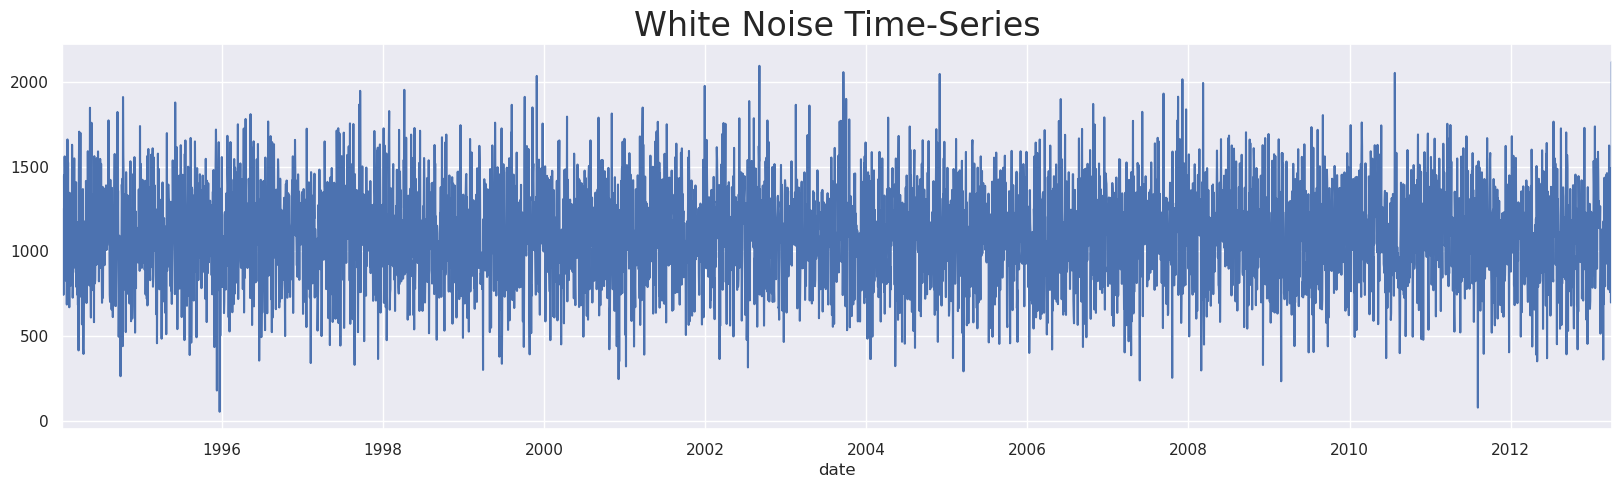

In [13]:
# Plot the white noise time series
df.wn.plot(figsize=(20, 5))
plt.title("White Noise Time-Series", size=24)
plt.show()

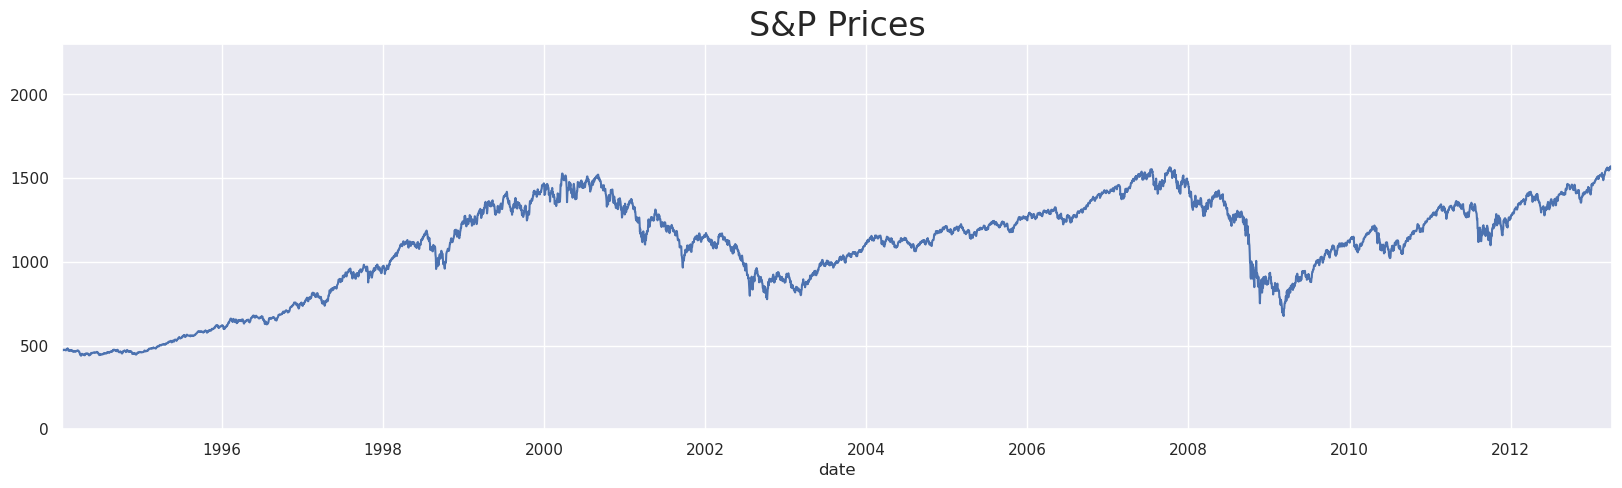

In [14]:
# Plot the S&P prices
df.market_value.plot(figsize=(20, 5))
plt.title("S&P Prices", size=24)
plt.ylim(0, 2300)
plt.show()

### Random Walk

A random walk is a stochastic process where each value is the sum of the previous value and a random step. In the context of time series, a random walk model suggests that the current value is equal to the previous value plus some random noise.


Characteristics:

- Non-stationary: The mean and variance are not constant over time.
- Unpredictable: Future values are not predictable from past values, except for the immediate past value.
- No Mean Reversion: Unlike mean-reverting processes, a random walk does not tend to return to a long-term mean.

In [15]:
# Read the random walk data from CSV
rw = pd.read_csv("RandWalk.csv")
rw.date = pd.to_datetime(rw.date, dayfirst=True)  # Convert 'date' to datetime format
rw.set_index("date", inplace=True)  # Set 'date' as the index
rw = rw.asfreq('b')  # Set frequency to business days

In [16]:
# Get a summary of the random walk DataFrame
rw.describe()

,price
count,5021.000000
mean,1269.944293
std,444.216793
min,585.483034
25%,931.550429
50%,1156.363045
75%,1488.362029
max,2715.508720


In [17]:
# Add the random walk price data to the main DataFrame
df['rw'] = rw.price

/tmp/ipykernel_201244/1865153876.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rw'] = rw.price


In [18]:
# Display the first few rows of the DataFrame to verify the addition of the random walk data
df.head()

,market_value,wn,rw
date,,,
1994-01-07,469.90,852.562743,1122.139662
1994-01-10,475.27,1116.717809,1080.347860
1994-01-11,474.13,939.340804,1082.095245
1994-01-12,474.17,1248.797677,1083.639265
1994-01-13,472.47,742.922938,1067.146255


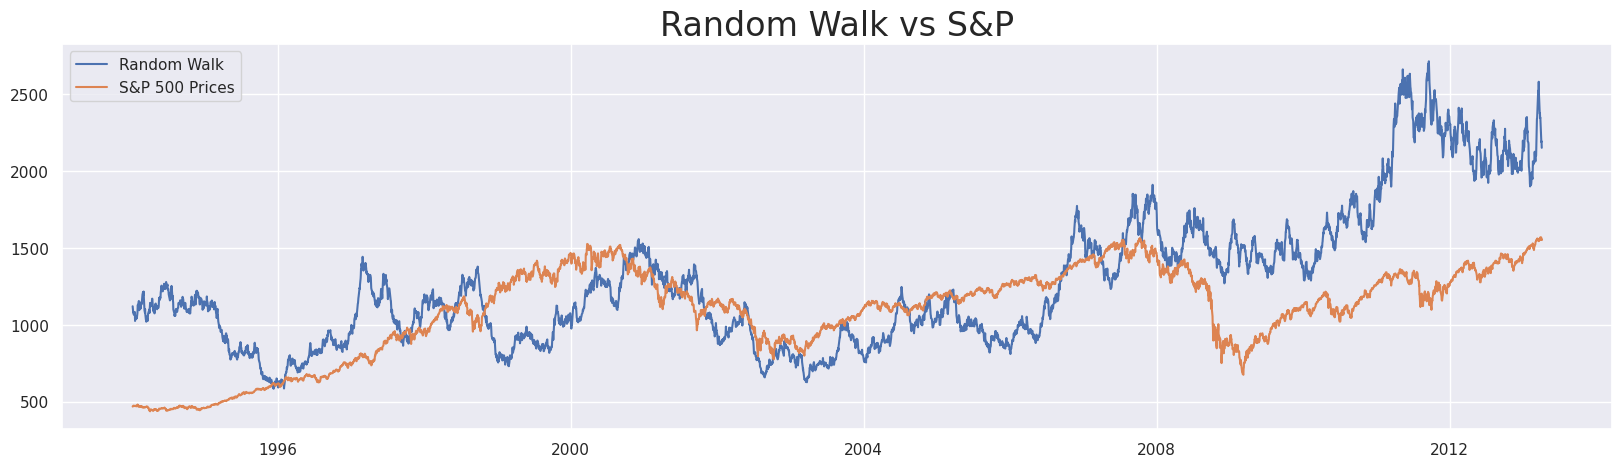

In [19]:
# Plot the random walk and S&P prices for comparison
plt.figure(figsize=(20, 5))
plt.plot(df.rw, label='Random Walk')  # Plot random walk series with label
plt.plot(df.market_value, label='S&P 500 Prices')  # Plot S&P market value series with label
plt.title("Random Walk vs S&P", size=24)  # Add title to the plot
plt.legend()  # Add legend to the plot
plt.show()  # Display the plot


### Stationarity

A time series is said to be stationary if its statistical properties such as mean, variance, and autocorrelation are constant over time. Stationarity is crucial for many time series analysis techniques and models, such as ARIMA, which assume that the underlying data is stationary.

Types of Stationarity:

- Strict Stationarity: The joint distribution of any subset of the series is identical to the joint distribution of the time-shifted subset.
- Weak (or Second-order) Stationarity: The mean, variance, and autocorrelation function do not change over time.

### Why Stationarity Matters:

Many time series models rely on the assumption of stationarity. If a time series is non-stationary, it may need to be transformed (e.g., differenced) to make it stationary before modeling.

### Augmented Dickey-Fuller (ADF) Test

The ADF test is a statistical test used to determine if a time series is stationary. It tests the null hypothesis that a unit root is present in the time series (i.e., the series is non-stationary).

Note: In hypothesis testing, the null hypothesis is a statement that there is no effect or no difference, and it is the hypothesis that researchers try to disprove or reject. In the context of the ADF test for time series data, the null hypothesis is that the time series has a unit root, meaning it is non-stationary.

        - Null Hypothesis in ADF Test: The series is non-stationary (has a unit root).
        - Alternative Hypothesis in ADF Test: The series is stationary (does not have a unit root).

Key Outputs of the ADF Test:

- ADF Statistic: A negative value; more negative indicates stronger rejection of the null hypothesis.
- p-value: If the p-value is below a certain threshold (commonly 0.05), the null hypothesis is rejected, indicating the series is stationary.
- Critical Values: The cut-off values at different confidence levels (1%, 5%, 10%) for rejecting the null hypothesis.

In [20]:
# Perform the Augmented Dickey-Fuller test on the S&P 500 market value series
adf_market_value = sts.adfuller(df.market_value)
print("ADF Test for Market Value:")
print(f"ADF Statistic: {adf_market_value[0]}")
print(f"p-value: {adf_market_value[1]}")
print("Critical Values:")
for key, value in adf_market_value[4].items():
    print(f"   {key}: {value}")

ADF Test for Market Value:
ADF Statistic: -1.736984745235245
p-value: 0.4121645696770616
Critical Values:
   1%: -3.431658008603046
   5%: -2.862117998412982
   10%: -2.567077669247375


### Interpretation

- p-value:

The p-value is 0.4121645696770616, which is greater than 0.05. This means we fail to reject the null hypothesis that the time series has a unit root.
A high p-value indicates that there is not enough evidence to conclude that the series is stationary.

- ADF Statistic vs. Critical Values:

The ADF statistic (-1.736984745235245) is not more negative than any of the critical values at the 1%, 5%, or 10% significance levels.
This further supports the conclusion that we fail to reject the null hypothesis.

#### Conclusion:

The S&P 500 market value series is non-stationary based on the ADF test results.

In [21]:
# Perform the Augmented Dickey-Fuller test on the white noise series
adf_wn = sts.adfuller(df.wn)
print("\nADF Test for White Noise:")
print(f"ADF Statistic: {adf_wn[0]}")
print(f"p-value: {adf_wn[1]}")
print("Critical Values:")
for key, value in adf_wn[4].items():
    print(f"   {key}: {value}")


ADF Test for White Noise:
ADF Statistic: -71.93016551422997
p-value: 0.0
Critical Values:
   1%: -3.431653316130827
   5%: -2.8621159253018247
   10%: -2.5670765656497516


### Interpretation

- p-value:

The p-value is 0.0, which is less than 0.05. This means we reject the null hypothesis that the time series has a unit root.
A low p-value indicates strong evidence against the null hypothesis, suggesting that the series is stationary.

- ADF Statistic vs. Critical Values:

The ADF statistic (-36.668828692817044) is much more negative than the critical values at the 1%, 5%, and 10% significance levels.
This further supports the conclusion that we reject the null hypothesis.

#### Conclusion:

The white noise series is stationary based on the ADF test results.

In [22]:
# Perform the Augmented Dickey-Fuller test on the random walk series
adf_rw = sts.adfuller(df.rw)
print("\nADF Test for Random Walk:")
print(f"ADF Statistic: {adf_rw[0]}")
print(f"p-value: {adf_rw[1]}")
print("Critical Values:")
for key, value in adf_rw[4].items():
    print(f"   {key}: {value}")


ADF Test for Random Walk:
ADF Statistic: -1.3286073927689712
p-value: 0.6159849181617387
Critical Values:
   1%: -3.4316595802782865
   5%: -2.8621186927706463
   10%: -2.567078038881065


### Interpretation

- p-value:

The p-value is 0.6159849181617387, which is greater than 0.05. This means we fail to reject the null hypothesis that the time series has a unit root.
A high p-value indicates that there is not enough evidence to conclude that the series is stationary.

- ADF Statistic vs. Critical Values:

The ADF statistic (-1.3286073927689712) is not more negative than any of the critical values at the 1%, 5%, or 10% significance levels.
This further supports the conclusion that we fail to reject the null hypothesis.

#### Conclusion:

The random walk series is non-stationary based on the ADF test results.

### Seasonality

seasonal_decompose(df.market_value, model="multiplicative"): Decomposes the market_value series into trend, seasonal, and residual components using a multiplicative model.

The plot produced by seasonal_decompose typically consists of four subplots:

- Observed: The original time series data. Shows the raw market_value data.
- Trend: The long-term trend component. Displays the general upward or downward movement over time.
- Seasonal: The seasonal component, showing repeating patterns at regular intervals. Highlights any periodic patterns, such as peaks and troughs that repeat annually, quarterly, monthly, etc.
- Residual: The residual or irregular component, capturing the noise in the data. Represents the random variation left after removing the trend and seasonal components.


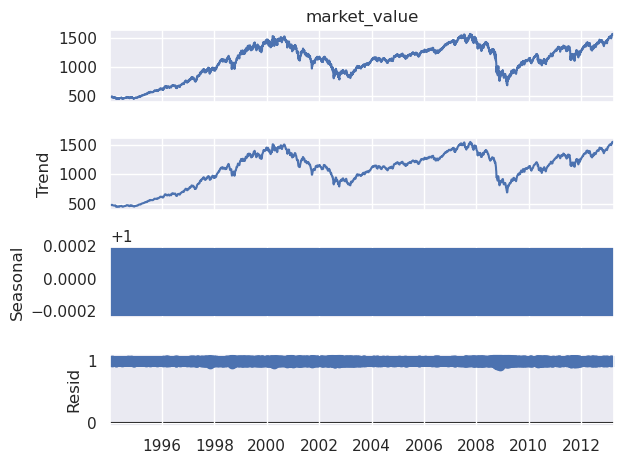

In [23]:
# Decompose the time series using a multiplicative model
s_dec_multiplicative = seasonal_decompose(df.market_value, model="multiplicative")

# Plot the decomposed components
s_dec_multiplicative.plot()
plt.show()

seasonal_decompose(df.market_value, model="additive"): Decomposes the market_value series into trend, seasonal, and residual components using an additive model.

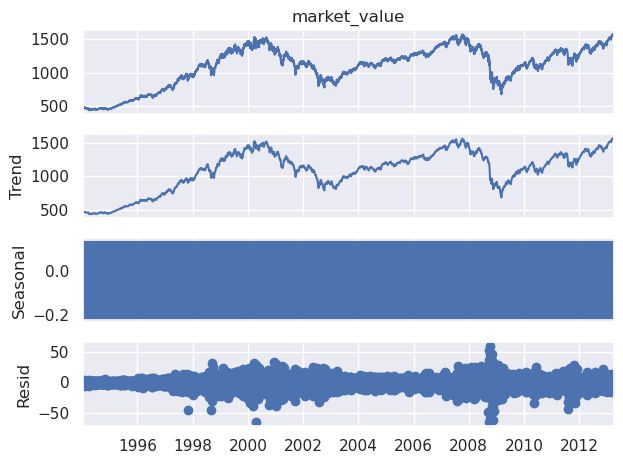

In [24]:
# Decompose the time series using an additive model
s_dec_additive = seasonal_decompose(df.market_value, model="additive")

# Plot the decomposed components
s_dec_additive.plot()
plt.show()

### Choosing Between Additive and Multiplicative Models

- Additive Model: Used when the seasonal variations are roughly constant over time.
- Multiplicative Model: Used when the seasonal variations change proportionally to the level of the time series.

### ACF

The Autocorrelation Function (ACF) is a fundamental tool in time series analysis. It measures the correlation between a time series and lagged versions of itself over successive time intervals. The ACF helps in identifying patterns such as seasonality and the presence of autocorrelation in the data.

### Interpreting the ACF Plot
    - The ACF plot shows the correlation between the time series and its lagged values. Here's how to interpret it:

#### Lag:

    - The x-axis represents the number of lags.
    - Each bar on the plot represents the correlation coefficient for the respective lag.

#### Correlation Coefficient:

    - The y-axis represents the correlation coefficient, ranging from -1 to 1.
    - Bars above the x-axis indicate positive autocorrelation, while bars below indicate negative autocorrelation.

#### Significance:

    - The horizontal blue lines represent the confidence intervals. If a bar extends beyond these lines, the correlation is statistically significant.

#### Pattern Recognition:

    - Seasonality: Regular patterns in the ACF plot indicate seasonality.
    - Autocorrelation: Significant correlations at various lags suggest autocorrelation in the data.

sgt.plot_acf(df.market_value, lags=40, zero=False): Plots the ACF for the market_value series with up to 40 lags. The parameter zero=False excludes the zero lag (the correlation of the series with itself at lag 0, which is always 1).

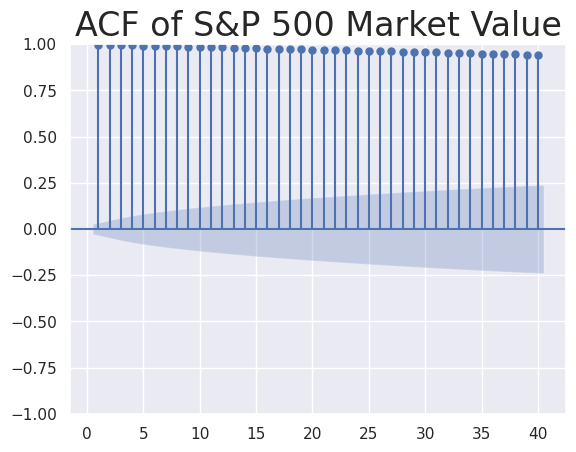

In [25]:
# Plot the Autocorrelation Function (ACF) for the S&P market value series
sgt.plot_acf(df.market_value, lags=40, zero=False)
plt.title("ACF of S&P 500 Market Value", size=24)
plt.show()

### PACF

The Partial Autocorrelation Function (PACF) measures the correlation between a time series and its lagged values, controlling for the values of the time series at all shorter lags. It helps in identifying the direct effect of a lagged value on the current value, excluding the influence of intermediate lags.

### Interpreting the PACF Plot

    - The PACF plot shows the partial correlation of the time series with its lagged values. Here's how to interpret it:

#### Lag:

    - The x-axis represents the number of lags. Each bar on the plot represents the partial correlation coefficient for the respective lag.

#### Partial Correlation Coefficient:

    - The y-axis represents the partial correlation coefficient, ranging from -1 to 1.
    - Bars above the x-axis indicate positive partial autocorrelation, while bars below indicate negative partial autocorrelation.

#### Significance:

    - The horizontal blue lines represent the confidence intervals. If a bar extends beyond these lines, the partial correlation is statistically significant.

#### Pattern Recognition:

    - Direct Effect: The PACF shows the direct effect of past values on the current value, removing the effect of intermediate lags.
    - Model Identification: Helps identify the order of the AR (Autoregressive) part of ARIMA models.


sgt.plot_pacf(df.market_value, lags=40, zero=False, method='ols'): Plots the PACF for the market_value series with up to 40 lags. The parameter zero=False excludes the zero lag. The method 'ols' is used for ordinary least squares regression to compute the PACF.

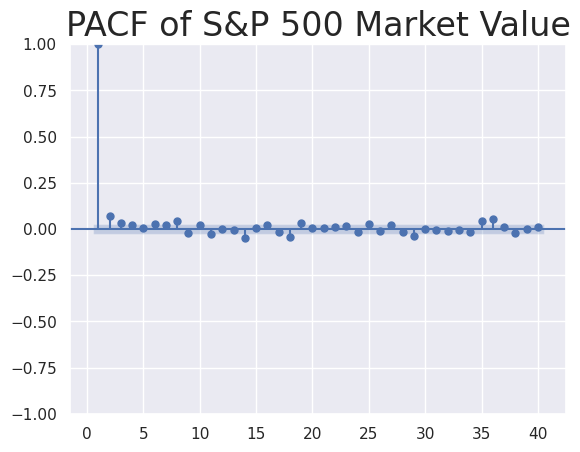

In [26]:
# Plot the Partial Autocorrelation Function (PACF) for the S&P market value series
sgt.plot_pacf(df.market_value, lags=40, zero=False, method='ols')
plt.title("PACF of S&P 500 Market Value", size=24)
plt.show()
